In [1]:
import warnings
import numpy
import pandas
import matplotlib.pyplot as plt
import modules.neurons as neu
import modules.input as inp
import modules.misc as misc
import modules.plot as p
import scipy.io
import scipy.optimize

warnings.filterwarnings('ignore')
numpy.seterr(all='ignore')

# loading experimental data
exp_data = inp.import_mc_experiment_matfile('data/experiments/hMC_IntrinsicParameters_normalSteps.mat',return_as_structtype=True)
exp_data.hMC_ISI[:,0]=exp_data.hMC_ISI[:,0]-1
exp_data.hMC_DeltaTheta[:,0]=exp_data.hMC_DeltaTheta[:,0]-1

exp_decay_data = pandas.read_table('data/experiments/MC_RAMP_Tau.dat',sep=' ', header=None, comment='#').to_numpy()

exp_lat_data = inp.import_mc_experiment_matfile('data/experiments/hMC_StepCurrent_1stLatency.mat',return_as_structtype=True)


exp_data_new = inp.import_mc_experiment_matfile('data/experiments/hMC_graphData.mat',return_as_structtype=True)
exp_data_new.avg_DeltaSpikeThreshold = numpy.insert(exp_data_new.avg_DeltaSpikeThreshold,0,(1,0,0),axis=0)
exp_data_new.avg_DeltaSpikeThreshold[:,0] -= 1

# loading model data
#spft_data = inp.import_model_currinj('data/simulations/no_K_curr/sim_EIFDTBoundSigKLR_spk_features.npz',return_as_structtype=True)
#spft_data = inp.import_model_currinj('data/simulations/no_K_curr/currinj_spk_feat_EIFDTBoundSigKLR_spk_features_2.npz',return_as_structtype=True)
#spft_data = inp.import_model_currinj('data/simulations/no_K_curr/currinj_spk_feat_EIFDTBoundSigKLR_spk_features_tauth300.npz',return_as_structtype=True)
spft_data = inp.import_model_currinj('data/simulations/no_K_curr/currinj_spk_feat_EIFDTBoundSigKLR_spk_features_longer.npz',return_as_structtype=True)
spft_data.ISI['spk'] = spft_data.ISI['spk'] - 1

#mod_decay_data = inp.fix_numpy_load('data/simulations/no_K_curr/thresh_decay_EIFDTBoundSigKLR_thresh_decay.npz',return_as_structtype=True)
mod_decay_data = inp.fix_numpy_load('data/simulations/no_K_curr/thresh_decay_EIFDTBoundSigKLR_thresh_decay_tauth300.npz',return_as_structtype=True)

init_spk_th_data = inp.fix_numpy_load('data/simulations/no_K_curr/theta_I_curve_EIFDTBoundSigKLR_th0_vs_I_3.npz',return_as_structtype=True)
init_spk_la_data = inp.fix_numpy_load('data/simulations/no_K_curr/theta_I_curve_EIFDTBoundSigKLR_latency_vs_I_2.npz',return_as_structtype=True)


rescaleCurr = False

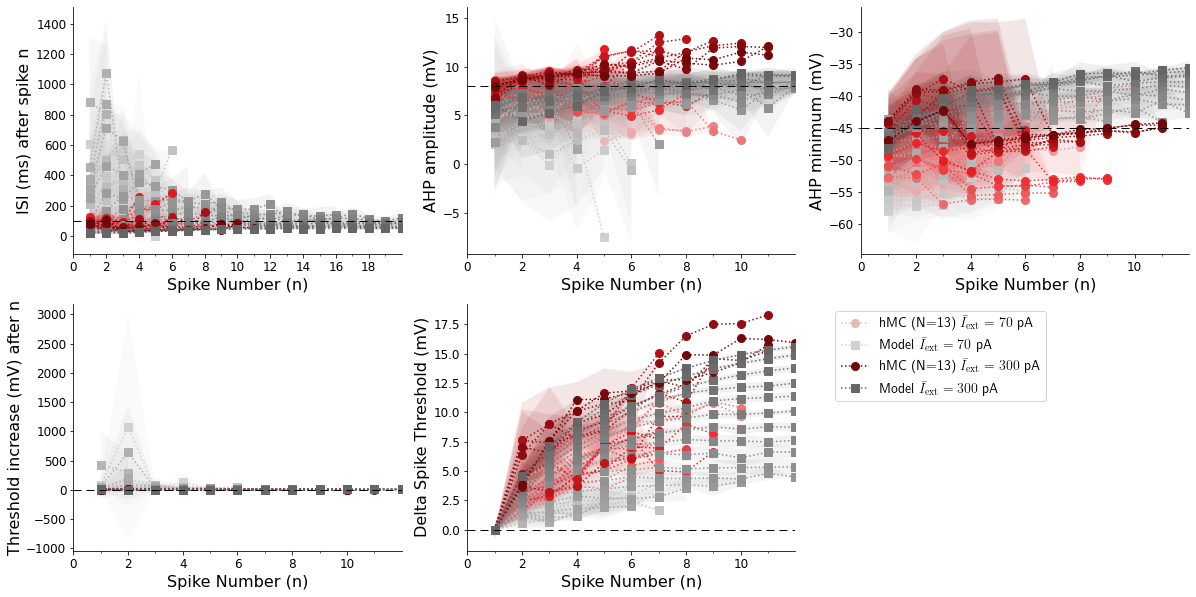

In [3]:
"""

Plotting quantities vs. spike # averaged over all input currents

"""

avgExpData   = 'none'
avgModelData = 'none'
avgRange=''

markersize=5

avg_data_struct = lambda s: inp.avg_data_matrix(s['avg'],s['std'],parVal=s['I'],avgType=avgModelData,axis=1,parValRange=avgRange,errorMethod='max',returnStdErr=False)

def plot_panel(ax,experiment_data_label,model_data,xLim,xLabel,yLabel,**errorfillArgs):
    x_exp,y_exp,yErr_exp,curr_exp = inp.get_mc_experiment_var(exp_data,experiment_data_label)
    y_exp,yErr_exp,curr_exp = inp.avg_data_matrix(y_exp,yErr_exp,parVal=curr_exp,avgType=avgExpData,axis=1,parValRange=avgRange)
    x_mod = model_data['spk']
    y_mod,yErr_mod,curr_mod = avg_data_struct(model_data)
    color_mc = p.get_red_gradient(curr_exp.size) #p.get_hot_colors(curr_exp.size)
    color_md = p.get_gray_gradient(curr_mod.size,f=0.2) #p.get_cold_colors(curr_mod.size)
    for k in range(curr_exp.size):
        lp = '' if ( (k==0) or (k==(curr_exp.size-1)) ) else '_'
        p.errorfill(x_exp+1,y_exp[:,k],yErr_exp[:,k],ax=ax,fmt=':o',color=color_mc[k], label=lp+'hMC (N=13) $\\bar{I}_{\\rm ext}=%.0f$ pA'%(curr_exp[k]), **errorfillArgs)
        p.errorfill(x_mod+1,y_mod[:,k],yErr_mod[:,k],ax=ax,fmt=':s',color=color_md[k],      label=lp+'Model $\\bar{I}_{\\rm ext}=%.0f$ pA'%(curr_mod[k]*1e3), **errorfillArgs)
    ax.set_xlabel(xLabel,fontsize=16)
    ax.set_ylabel(yLabel,fontsize=16)
    ax.set_xlim(xLim)
    ax.set_xticks(numpy.arange(xLim[1])[::2])
    ax.set_xticks(numpy.arange(xLim[1])[1::2],minor=True)

fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(20,10))

"""
*****************************     ISI    *******************************
"""
plot_panel(ax[0,0],'hMC_ISI',spft_data.ISI,(0,20),'Spike Number (n)','ISI (ms) after spike n',markersize=8,alpha_fill=0.1)
ax[0,0].axhline(y=100,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5))


"""
*****************************     AHP Amplitude    *******************************
"""
plot_panel(ax[0,1],'hMC_AHP_Ampl',spft_data.AHPAmp,[0,12],'Spike Number (n)','AHP amplitude (mV)',markersize=8,alpha_fill=0.1)
ax[0,1].axhline(y=8,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5))


"""
*****************************     AHP Minimum    *******************************
"""
plot_panel(ax[0,2],'hMC_AHP_Min',spft_data.AHPMin,[0,12],'Spike Number (n)','AHP minimum (mV)',markersize=8,alpha_fill=0.1)
ax[0,2].axhline(y=-45,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5))


"""
*****************************     Delta Theta    *******************************
"""
plot_panel(ax[1,0],'hMC_DeltaTheta',spft_data.DeltaTh,[0,12],'Spike Number (n)','Threshold increase (mV) after n',markersize=8,alpha_fill=0.1)
ax[1,0].axhline(y=3,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5))
#avg_data_struct = lambda s: inp.avg_data_matrix(s['avg'],s['std'],parVal=s['I'],avgType=avgModelData,axis=1,parValRange=avgRange,errorMethod='max',returnStdErr=False)


"""
*****************************     Spike Threshold    *******************************
"""
plot_panel(ax[1,1],'hMC_SpikeThreshold_Diff',spft_data.SpkThDiff,[0,12],'Spike Number (n)','Delta Spike Threshold (mV)',markersize=8,alpha_fill=0.1)
ax[1,1].axhline(y=0,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5))
#avg_data_struct = lambda s: inp.avg_data_matrix(s['avg'],s['std'],parVal=s['I'],avgType=avgModelData,axis=1,parValRange=avgRange,errorMethod='max',returnStdErr=False)

plt.rcParams.update({'text.usetex':True,'font.family':'serif'})
ax[1,1].legend(fontsize=14,bbox_to_anchor=(1.1,1),loc='upper left')
plt.rcParams.update({'text.usetex':False,'font.family':'sans-serif'})


"""
*****************************     Threshold Decay    *******************************
"""

for a in ax.flatten():
    a.tick_params(labelsize=12)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
ax[1,2].set_visible(False)

#p.plot_param_search_var(x_exp,y_exp,yErr_exp,curr_exp,dict(spk=spft_data.ISI['spk'],avg=y_mod,std=yErr_mod,I=curr_mod),rescale_currents=rescaleCurr,ylabel_txt='$\\overline{ISI}$ (ms) after spike #',xLim_spk=[0,15])

# plt.savefig('figs/mc_1st_spike_model_dyn.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

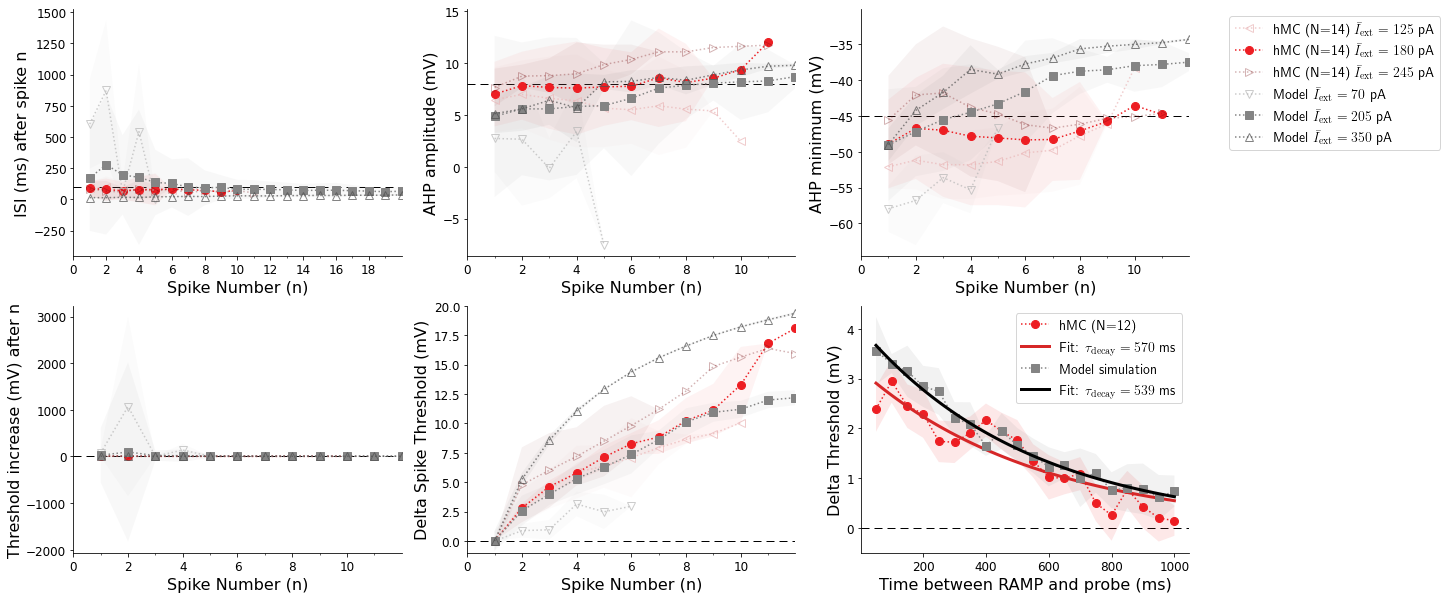

In [3]:
"""

Plotting quantities vs. spike # averaged over all input currents

"""

avgExpData   = 'all'
avgModelData = 'all'
avgRange=''

#color_mc = numpy.asarray((237.0/255.0,30.0/255.0,35.0/255.0,1),dtype=float)
#color_md = numpy.asarray((0,0,0,1),dtype=float)

color_mc = p.get_red_gradient(3)#p.get_hot_colors(3,f=0.2)
color_mc[0,-1] = 0.7 # changing the alpha of these colors
color_mc[2,-1] = 0.3 # changing the alpha of these colors

color_md = p.get_gray_gradient(3,f=0.2) #p.get_cold_colors(3)
color_md[0,-1] = 0.7 # changing the alpha of these colors
color_md[2,-1] = 0.7 # changing the alpha of these colors

avg_data_struct = lambda s: inp.avg_data_matrix(s['avg'],s['std'],parVal=s['I'],avgType=avgModelData,axis=1,parValRange=avgRange,errorMethod='max',returnStdErr=False)

def plot_panel(ax,experiment_data_label,model_data,xLim,xLabel,yLabel,km_lower=0,km_upper=-1,yLim=None,**errorfillArgs):
    x_exp_all,y_exp_all,yErr_exp_all,curr_exp_all = inp.get_mc_experiment_var(exp_data,experiment_data_label)
    x_exp = x_exp_all
    y_exp,yErr_exp,curr_exp = inp.avg_data_matrix(y_exp_all,yErr_exp_all,parVal=curr_exp_all,avgType=avgExpData,axis=1,parValRange=avgRange)
    if experiment_data_label == 'hMC_SpikeThreshold_Diff':
        x_exp,y_exp,yErr_exp = exp_data_new['avg_DeltaSpikeThreshold'][:,0],exp_data_new['avg_DeltaSpikeThreshold'][:,1],exp_data_new['avg_DeltaSpikeThreshold'][:,2]
    y_exp_hl,yErr_exp_hl,curr_exp_hl = inp.avg_data_matrix(y_exp_all,yErr_exp_all,parVal=curr_exp_all,avgType='hilo',axis=1,parValRange=avgRange)
    x_mod = model_data['spk']
    y_mod,yErr_mod,curr_mod = avg_data_struct(model_data)
    p.errorfill(x_exp_all+1,y_exp_hl[:,0],yErr_exp_hl[:,0],ax=ax,fmt=':<',color=color_mc[0], label='hMC (N=14) $\\bar{I}_{\\rm ext}=%.0f$ pA'%(curr_exp_hl[0]), fillstyle='none', **errorfillArgs)
    #p.errorfill(x_exp_all+1,y_exp_all[:,0],yErr_exp_all[:,0],ax=ax,fmt=':<',color=color_mc[0], label='hMC (N=13) $\\bar{I}_{\\rm ext}=%.0f$ pA'%(curr_exp_hl[0]), fillstyle='none', **errorfillArgs)
    p.errorfill(x_exp+1,y_exp,yErr_exp,ax=ax,fmt=':o',color=color_mc[1], label='hMC (N=14) $\\bar{I}_{\\rm ext}=%.0f$ pA'%(curr_exp), **errorfillArgs)
    #p.errorfill(x_exp_all+1,y_exp_all[:,-1],yErr_exp_all[:,-1],ax=ax,fmt=':>',color=color_mc[2], label='hMC (N=13) $\\bar{I}_{\\rm ext}=%.0f$ pA'%(curr_exp_hl[1]), fillstyle='none', **errorfillArgs)
    p.errorfill(x_exp_all+1,y_exp_hl[:,1],yErr_exp_hl[:,1],ax=ax,fmt=':>',color=color_mc[2], label='hMC (N=14) $\\bar{I}_{\\rm ext}=%.0f$ pA'%(curr_exp_hl[1]), fillstyle='none', **errorfillArgs)
    if not (km_lower is None):
        p.errorfill(x_mod+1,model_data['avg'][:,km_lower],model_data['std'][:,km_lower],ax=ax,fmt=':v',color=color_md[0], label='Model $\\bar{I}_{\\rm ext}=%.0f$ pA'%(model_data['I'][km_lower]*1e3),  fillstyle='none',**errorfillArgs)
    p.errorfill(x_mod+1,y_mod,yErr_mod,ax=ax,fmt=':s',color=color_md[1],      label='Model $\\bar{I}_{\\rm ext}=%.0f$ pA'%(curr_mod*1e3), **errorfillArgs)
    if not(km_upper is None):
        p.errorfill(x_mod+1,model_data['avg'][:,km_upper],model_data['std'][:,km_upper],ax=ax,fmt=':^',color=color_md[2], label='Model $\\bar{I}_{\\rm ext}=%.0f$ pA'%(model_data['I'][km_upper]*1e3),  fillstyle='none',**errorfillArgs)
    ax.set_xlabel(xLabel,fontsize=16)
    ax.set_ylabel(yLabel,fontsize=16)
    ax.set_xlim(xLim)
    ax.set_xticks(numpy.arange(xLim[1])[::2])
    ax.set_xticks(numpy.arange(xLim[1])[1::2],minor=True)
    if yLim:
        ax.set_ylim(yLim)

fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(20,10))

idx_lower = 0

"""
*****************************     ISI    *******************************
"""
plot_panel(ax[0,0],'hMC_ISI',spft_data.ISI,(0,20),'Spike Number (n)','ISI (ms) after spike n',km_lower=idx_lower,markersize=8,alpha_fill=0.05)
ax[0,0].axhline(y=100,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5),zorder=-10)


"""
*****************************     AHP Amplitude    *******************************
"""
plot_panel(ax[0,1],'hMC_AHP_Ampl',spft_data.AHPAmp,[0,12],'Spike Number (n)','AHP amplitude (mV)',km_lower=idx_lower,markersize=8,alpha_fill=0.05)
ax[0,1].axhline(y=8,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5),zorder=-10)


"""
*****************************     AHP Minimum    *******************************
"""
plot_panel(ax[0,2],'hMC_AHP_Min',spft_data.AHPMin,[0,12],'Spike Number (n)','AHP minimum (mV)',km_lower=idx_lower,markersize=8,alpha_fill=0.05)
ax[0,2].axhline(y=-45,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5),zorder=-10)


"""
*****************************     Delta Theta    *******************************
"""
plot_panel(ax[1,0],'hMC_DeltaTheta',spft_data.DeltaTh,[0,12],'Spike Number (n)','Threshold increase (mV) after n',km_lower=idx_lower,markersize=8,alpha_fill=0.05)
ax[1,0].axhline(y=3,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5),zorder=-10)
#avg_data_struct = lambda s: inp.avg_data_matrix(s['avg'],s['std'],parVal=s['I'],avgType=avgModelData,axis=1,parValRange=avgRange,errorMethod='max',returnStdErr=False)


"""
*****************************     Spike Threshold    *******************************
"""
plot_panel(ax[1,1],'hMC_SpikeThreshold_Diff',spft_data.SpkThDiff,[0,12],'Spike Number (n)','Delta Spike Threshold (mV)',km_lower=idx_lower,yLim=[-1,20],markersize=8,alpha_fill=0.05)
ax[1,1].axhline(y=0,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5),zorder=-10)
#avg_data_struct = lambda s: inp.avg_data_matrix(s['avg'],s['std'],parVal=s['I'],avgType=avgModelData,axis=1,parValRange=avgRange,errorMethod='max',returnStdErr=False)

plt.rcParams.update({'text.usetex':True,'font.family':'serif'})
ax[0,2].legend(fontsize=14,bbox_to_anchor=(1.1,1),loc='upper left')
plt.rcParams.update({'text.usetex':False,'font.family':'sans-serif'})

"""
*****************************     Threshold Decay    *******************************
"""
exp_data_thresh_decay_anhtuan = numpy.array([[50.0,2.38889],[100.0,2.94444],[150.0,2.44444],[200.0,2.2963],[250.0,1.74074],[300.0,1.72222],[350.0,1.90741],[400.0,2.16667],[450.0,1.94444],[500.0,1.75926],[550.0,1.35185],[600.0,1.01852],[650.0,1],[700.0,1.09259],[750.0,0.5],[800.0,0.259259],[850.0,0.777778],[900.0,0.425926],[950.0,0.203704],[1000.0,0.148148]])
mod_decay_data.fitParam_data = numpy.array((3.175,0.00175377))

color_mc = color_mc[1]#numpy.asarray((237.0/255.0,30.0/255.0,35.0/255.0,1),dtype=float)
color_md = color_md[1]
color_md[-1] = 1.0
fit_exp_func = lambda xx,a,b: a * numpy.exp(-b * xx)
x_fit = numpy.linspace(mod_decay_data.DeltaTexp[0],mod_decay_data.DeltaTexp[-1],100)
#p.errorfill(exp_decay_data[:,0], exp_decay_data[:,1], exp_decay_data[:,2],markersize=8,alpha_fill=0.1, fmt=':o',color=color_mc, label='hMC (N=12)',ax=ax[1,2])
p.errorfill(exp_data_thresh_decay_anhtuan[:,0], exp_data_thresh_decay_anhtuan[:,1], exp_decay_data[:,2],markersize=8,alpha_fill=0.1, fmt=':o',color=color_mc, label='hMC (N=12)',ax=ax[1,2])
ax[1,2].plot(x_fit, fit_exp_func(x_fit,*mod_decay_data.fitParam_data),'-',linewidth=3,color='tab:red', label='Fit: $\\tau_{\\rm decay}=%.0f$ ms'%(1.0/mod_decay_data.fitParam_data[1]))
p.errorfill(mod_decay_data.DeltaTexp,mod_decay_data.th_amp,mod_decay_data.th_std,ax=ax[1,2],fmt=':s',color=color_md,markersize=8,alpha_fill=0.1, label='Model simulation')
ax[1,2].plot(x_fit, fit_exp_func(x_fit,*mod_decay_data.fitParam_model),'-',linewidth=3,color='k', label='Fit: $\\tau_{\\rm decay}=%.0f$ ms'%(1.0/mod_decay_data.fitParam_model[1]))
ax[1,2].axhline(y=0,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5),zorder=-10)
plt.rcParams.update({'text.usetex':True,'font.family':'serif'})
ax[1,2].legend(fontsize=14)
plt.rcParams.update({'text.usetex':False,'font.family':'sans-serif'})
ax[1,2].set_xlabel('Time between RAMP and probe (ms)',fontsize=16)
ax[1,2].set_ylabel('Delta Threshold (mV)',fontsize=16)
#ax[1,2].set_xlim([0,12])
#ax[1,2].set_xticks(numpy.arange(12)[::2])
#ax[1,2].set_xticks(numpy.arange(12)[1::2],minor=True)

for a in ax.flatten():
    a.tick_params(labelsize=12)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

#p.plot_param_search_var(x_exp,y_exp,yErr_exp,curr_exp,dict(spk=spft_data.ISI['spk'],avg=y_mod,std=yErr_mod,I=curr_mod),rescale_currents=rescaleCurr,ylabel_txt='$\\overline{ISI}$ (ms) after spike #',xLim_spk=[0,15])

plt.savefig('data/simulations/spk_features_noKcurr.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

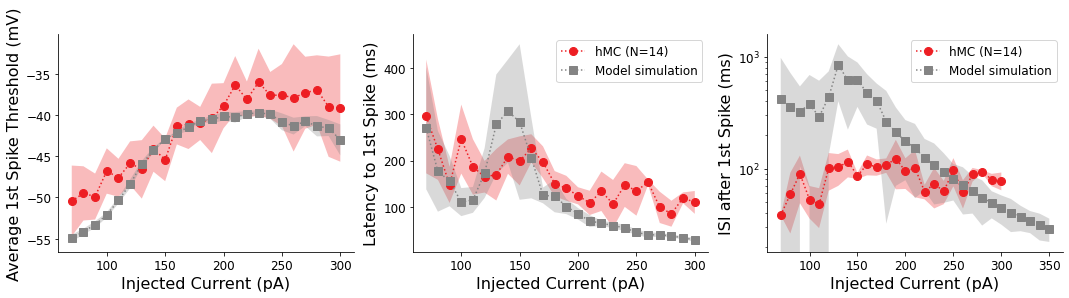

In [13]:
_,th_exp,therr_exp,I_exp = inp.get_mc_experiment_var(exp_data,'hMC_SpikeThreshold',transpose=True)
I_mc_for_lat = exp_lat_data.hMC_1stLatency_AVG[:,0].flatten()
t0spk_mc = exp_lat_data.hMC_1stLatency_AVG[:,1].flatten()
t0spk_err_mc = exp_lat_data.hMC_1stLatency_AVG[:,2].flatten()

spkn = init_spk_th_data.spkn if numpy.isscalar(init_spk_th_data.spkn) else init_spk_th_data.spkn[0]
I_model = init_spk_th_data.Irescaled
th_model = init_spk_th_data.th
thstd_model = init_spk_th_data.th_std

I_model_la = init_spk_la_data.Irescaled
tspk_mod = init_spk_la_data.tspk
tspk_std_mod = init_spk_la_data.tspk_std

if numpy.isscalar(spkn):
    color_mc = p.get_red_gradient(1)
    color_md = p.get_gray_gradient(3,f=0.2)[1,:]
    #color_mc = p.get_hot_colors(3,f=0.2)
    #color_md = p.get_cold_colors(3)
    #color_mc = color_mc[1]
    #color_md = color_md[1]
else:
    color_mc = p.get_red_gradient(spkn.size)
    color_md = p.get_gray_gradient(spkn.size,f=0.2)

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(18,4))

x_max_ax = None

I_exp_new,th_exp_new,thErr_exp_new = exp_data_new.avg_1st_SpikeThreshold_Curr[:,0],exp_data_new.avg_1st_SpikeThreshold_Curr[:,1],exp_data_new.avg_1st_SpikeThreshold_Curr[:,2]
p.errorfill(I_exp_new,th_exp_new,thErr_exp_new,fmt=':o', label='hMC (N=14)',color=color_mc,ax=ax[0],markersize=8)
p.errorfill(I_model,th_model[:,spkn],thstd_model[:,spkn],fmt=':s', color=color_md,ax=ax[0],label='Model simulation',markersize=8)
ax[0].set_xlabel('Injected Current (pA)',fontsize=16)
ax[0].set_ylabel('Average 1st Spike Threshold (mV)',fontsize=16)
if not(x_max_ax is None):
    ax[0].set_xlim(xmax=x_max_ax)
#ax[0].legend(fontsize=12)

I_exp_new,th_exp_new,thErr_exp_new = exp_data_new.avg_1st_latency_Curr[:,0],exp_data_new.avg_1st_latency_Curr[:,1],exp_data_new.avg_1st_latency_Curr[:,2]
p.errorfill(I_exp_new,th_exp_new,thErr_exp_new,fmt=':o', label='hMC (N=14)',color=color_mc,ax=ax[1],markersize=8)
p.errorfill(I_model,tspk_mod,tspk_std_mod,fmt=':s', color=color_md,ax=ax[1],label='Model simulation',markersize=8)
ax[1].set_xlabel('Injected Current (pA)',fontsize=16)
ax[1].set_ylabel('Latency to 1st Spike (ms)',fontsize=16)
if not(x_max_ax is None):
    ax[1].set_xlim(xmax=x_max_ax)
ax[1].legend(fontsize=12)

I_exp_new,th_exp_new,thErr_exp_new = exp_data_new.avg_1st_ISI_Curr[:,0],exp_data_new.avg_1st_ISI_Curr[:,1],exp_data_new.avg_1st_ISI_Curr[:,2]
p.errorfill(I_exp_new,th_exp_new,thErr_exp_new,fmt=':o', label='hMC (N=14)',color=color_mc,ax=ax[2],markersize=8)
y_mod,yErr_mod,curr_mod = inp.avg_data_matrix(spft_data.ISI['avg'],spft_data.ISI['std'],parVal=spft_data.ISI['I'],avgType='all',axis=0,parValRange='',errorMethod='max',returnStdErr=False)
p.errorfill(spft_data.ISI['I']*1e3,y_mod,yErr_mod,fmt=':s', color=color_md,ax=ax[2],label='Model simulation',markersize=8)
ax[2].set_xlabel('Injected Current (pA)',fontsize=16)
ax[2].set_ylabel('ISI after 1st Spike (ms)',fontsize=16)
ax[2].set_yscale('log')
if not(x_max_ax is None):
    ax[2].set_xlim(xmax=x_max_ax)
ax[2].legend(fontsize=12)

for a in ax.flatten():
    a.tick_params(labelsize=12)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

plt.savefig('data/simulations/first_spike_noKcurr.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

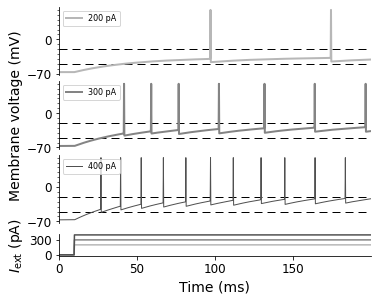

In [47]:
paramset = 'EIFDTBoundSigKLR'
neuronArgs = neu.GetDefaultParamSet(paramset)
neuronArgs['DeltaGK'] = 0.0
neuronArgs['noiseStd'] = 0.02
stimArgs = inp.get_input_stimulus_args()
stimArgs['stimtype'] = 'Step'
stimArgs['I0'] = [0.2,0.3,0.4]
stimArgs['tStim'] = 10.0
stimArgs['DeltaTStim'] = 190.0
T = 200.0

simArgs = {
            **neuronArgs,
            'ntrials': 1,
            'dt': 0.2,
            'noiseSignal': lambda:0.0
            }

t,I,V,th,g1,g2 = neu.RunSingleNeuron(T,stimArgs,**simArgs)

color_md = p.get_gray_gradient(3,f=0.05)#p.get_cold_colors(len(stimArgs['I0'])*10,f=0.8)
#color_md = color_md[[-1,15,0],:]

fig,ax = plt.subplots(nrows=4,ncols=1,sharex=False,sharey=False,squeeze=True,figsize=(5.1,3.8))
ax[0].set_position([0.15,0.74,0.85,0.25])
ax[1].set_position([0.15,0.47,0.85,0.25])
ax[2].set_position([0.15,0.20,0.85,0.25])
ax[3].set_position([0.15,0.08,0.85,0.08])
lw = [2,2,1]
for k in range(len(V)):
    ax[k].plot(t,V[k][0],c=color_md[k],linewidth=lw[k],label='%d pA'%(stimArgs['I0'][k]*1e3))
    ax[-1].plot(t,I[k]*1e3,c=color_md[k],label='%d pA'%(stimArgs['I0'][k]*1e3))
    ax[k].axhline(y=-50,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5),zorder=-10)
    ax[k].axhline(y=-20,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5),zorder=-10)
    ax[k].tick_params(labelsize=12)
    ax[k].set_xticks([])
    ax[k].set_xlim((0,T))
    ax[k].set_yticks(numpy.arange(-70,70,10),minor=True)
    ax[k].set_yticks([-70,0])
    ax[k].spines['right'].set_visible(False)
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['bottom'].set_visible(False)
    ax[k].legend(bbox_to_anchor=(0,1),loc='upper left',fontsize=8)
plt.rcParams.update({'text.usetex':True,'font.family':'serif'})
ax[1].set_ylabel('Membrane voltage (mV)',fontsize=14)
ax[-1].set_ylabel('$I_{\\rm ext}$ (pA)',fontsize=14)
plt.rcParams.update({'text.usetex':False,'font.family':'sans-serif'})
ax[-1].set_xlabel('Time (ms)',fontsize=14)
ax[-1].set_xlim((0,T))
ax[-1].set_xticks(numpy.arange(0,200,50))
ax[-1].set_yticks([0,300])
ax[-1].tick_params(labelsize=12)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['top'].set_visible(False)
#ax[-1].legend(bbox_to_anchor=(0.5,1),loc='lower center',fontsize=8)

plt.savefig('data/simulations/model_spikes_noKcurr.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

In [4]:
"""

loading data for simulations with different parameter sets

"""

spft_data = inp.import_model_currinj([
    'data/simulations/no_K_curr/currinj_spk_feat_EIFDTBoundSigKLR_spk_features_tauth300.npz',
    'data/simulations/no_K_curr/currinj_spk_feat_EIFDTBoundSigKLR_spk_features_Dth3.npz',
    'data/simulations/no_K_curr/currinj_spk_feat_EIFDTBoundSigKLR_spk_features_I0_0.13.npz',
    'data/simulations/no_K_curr/currinj_spk_feat_EIFDTBoundSigKLR_spk_features_taurth10.npz',
    'data/simulations/no_K_curr/currinj_spk_feat_EIFDTBoundSigKLR_spk_features_taurth30.npz',
    'data/simulations/no_K_curr/currinj_spk_feat_EIFDTBoundSigKLR_spk_features_2.npz'],return_as_structtype=True)
for i in range(len(spft_data.ISI)):
    spft_data.ISI[i]['spk'] = spft_data.ISI[i]['spk'] - 1

mod_decay_data = inp.import_model_currinj([
    'data/simulations/no_K_curr/thresh_decay_EIFDTBoundSigKLR_thresh_decay_tauth300.npz',
    'data/simulations/no_K_curr/thresh_decay_EIFDTBoundSigKLR_thresh_decay_Dth3.npz',
    'data/simulations/no_K_curr/thresh_decay_EIFDTBoundSigKLR_thresh_decay_I0_0.13.npz',
    'data/simulations/no_K_curr/thresh_decay_EIFDTBoundSigKLR_thresh_decay_taurth10.npz',
    'data/simulations/no_K_curr/thresh_decay_EIFDTBoundSigKLR_thresh_decay_taurth30.npz',
    'data/simulations/no_K_curr/thresh_decay_EIFDTBoundSigKLR_thresh_decay.npz'],return_as_structtype=True)

init_spk_th_data = inp.import_model_currinj([
    'data/simulations/no_K_curr/theta_I_curve_EIFDTBoundSigKLR_th0_vs_I_3.npz',
    'data/simulations/no_K_curr/theta_I_curve_EIFDTBoundSigKLR_th0_vs_I_I0_0.13.npz',
    'data/simulations/no_K_curr/theta_I_curve_EIFDTBoundSigKLR_th0_vs_I_taurth10.npz',
    'data/simulations/no_K_curr/theta_I_curve_EIFDTBoundSigKLR_th0_vs_I_taurth30.npz'],return_as_structtype=True)

init_spk_la_data = inp.import_model_currinj([
    'data/simulations/no_K_curr/theta_I_curve_EIFDTBoundSigKLR_latency_vs_I_2.npz',
    'data/simulations/no_K_curr/theta_I_curve_EIFDTBoundSigKLR_latency_vs_I_I0_0.13.npz',
    'data/simulations/no_K_curr/theta_I_curve_EIFDTBoundSigKLR_latency_vs_I_taurth10.npz',
    'data/simulations/no_K_curr/theta_I_curve_EIFDTBoundSigKLR_latency_vs_I_taurth30.npz'],return_as_structtype=True)




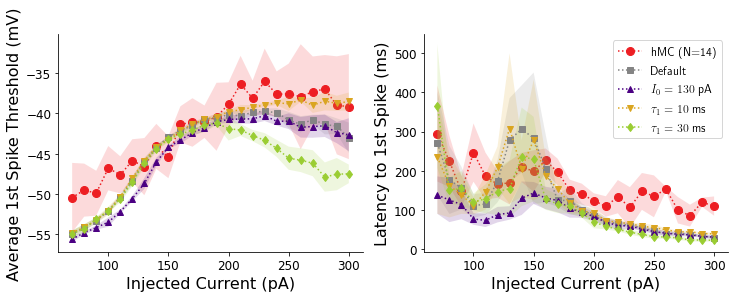

In [43]:
_,th_exp,therr_exp,I_exp = inp.get_mc_experiment_var(exp_data,'hMC_SpikeThreshold',transpose=True)
I_mc_for_lat = exp_lat_data.hMC_1stLatency_AVG[:,0].flatten()
t0spk_mc = exp_lat_data.hMC_1stLatency_AVG[:,1].flatten()
t0spk_err_mc = exp_lat_data.hMC_1stLatency_AVG[:,2].flatten()

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4))

alpha_fill = 0.16
#color_mc = p.get_hot_colors(3,f=0.2)
#color_mc = color_mc[1]
color_mc = p.get_red_gradient(1)

I_exp_new,th_exp_new,thErr_exp_new = exp_data_new.avg_1st_SpikeThreshold_Curr[:,0],exp_data_new.avg_1st_SpikeThreshold_Curr[:,1],exp_data_new.avg_1st_SpikeThreshold_Curr[:,2]
p.errorfill(I_exp_new,th_exp_new,thErr_exp_new,fmt=':o', label='hMC (N=14)',color=color_mc,ax=ax[0],markersize=8,zorder=-20,alpha_fill=alpha_fill)
I_exp_new,th_exp_new,thErr_exp_new = exp_data_new.avg_1st_latency_Curr[:,0],exp_data_new.avg_1st_latency_Curr[:,1],exp_data_new.avg_1st_latency_Curr[:,2]
p.errorfill(I_exp_new,th_exp_new,thErr_exp_new,fmt=':o', label='hMC (N=14)',color=color_mc,ax=ax[1],markersize=8,zorder=-20,alpha_fill=alpha_fill)

l_fmt = [':s',':^',':v',':d']
color_md = p.get_gray_gradient(3,f=0.2) #p.get_cold_colors(3)
color_md = [ color_md[1], 'indigo', 'goldenrod', 'yellowgreen' ]

label_md = [
    'Default',
    '$I_0={:g}$ pA'.format(init_spk_th_data.neuronArgs[1]['lf_I0']*1e3),
    '$\\tau_1={:g}$ ms'.format(init_spk_th_data.neuronArgs[2]['tauRiseTheta']),
    '$\\tau_1={:g}$ ms'.format(init_spk_th_data.neuronArgs[3]['tauRiseTheta']) ]

for i in range(len(init_spk_th_data.th)):
    spkn = init_spk_th_data.spkn[i] if numpy.isscalar(init_spk_th_data.spkn[i]) else init_spk_th_data.spkn[i][0]
    I_model = init_spk_th_data.Irescaled[i]
    th_model = init_spk_th_data.th[i]
    thstd_model = init_spk_th_data.th_std[i]

    I_model_la = init_spk_la_data.Irescaled[i]
    tspk_mod = init_spk_la_data.tspk[i]
    tspk_std_mod = init_spk_la_data.tspk_std[i]

    p.errorfill(I_model,th_model[:,spkn],thstd_model[:,spkn],fmt=l_fmt[i], color=color_md[i],ax=ax[0],label=label_md[i],markersize=6,alpha_fill=alpha_fill)
    p.errorfill(I_model,tspk_mod,tspk_std_mod,fmt=l_fmt[i], color=color_md[i],ax=ax[1],               label=label_md[i],markersize=6,alpha_fill=alpha_fill)

ax[0].set_xlabel('Injected Current (pA)',fontsize=16)
ax[0].set_ylabel('Average 1st Spike Threshold (mV)',fontsize=16)
ax[1].set_xlabel('Injected Current (pA)',fontsize=16)
ax[1].set_ylabel('Latency to 1st Spike (ms)',fontsize=16)
plt.rcParams.update({'text.usetex':True,'font.family':'serif'})
ax[1].legend(fontsize=12)
plt.rcParams.update({'text.usetex':False,'font.family':'sans-serif'})
for a in ax.flatten():
    a.tick_params(labelsize=12)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

plt.savefig('data/simulations/first_spike_noKcurr_comparison.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

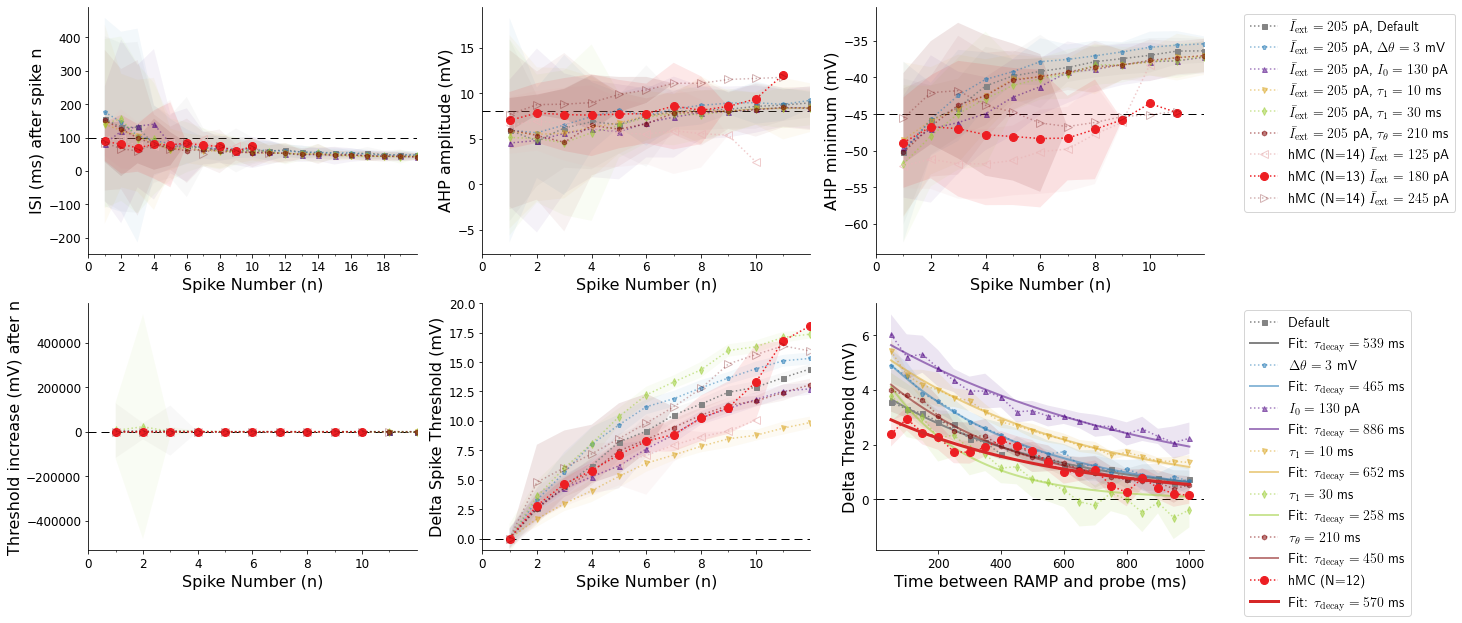

In [5]:
"""

Plotting quantities vs. spike # averaged over all input currents

"""

avgExpData   = 'all'
avgModelData = 'all'
avgRange=''

avg_data_struct = lambda s: inp.avg_data_matrix(s['avg'],s['std'],parVal=s['I'],avgType=avgModelData,axis=1,parValRange=avgRange,errorMethod='max',returnStdErr=False)

#color_mc = numpy.asarray((237.0/255.0,30.0/255.0,35.0/255.0,1),dtype=float)
#color_md = numpy.asarray((0,0,0,1),dtype=float)

color_mc = p.get_red_gradient(3) #p.get_hot_colors(3,f=0.2)
color_mc[0,-1] = 0.7
color_mc[2,-1] = 0.3

markersize = 5
l_fmt = [':s',':p',':^',':v',':d',':h']
color_md = p.get_gray_gradient(3,f=0.2) #p.get_cold_colors(3)
color_md = [
    color_md[1], 
    numpy.array([0.12156863, 0.46666667, 0.70588236, 0.5]),#numpy.array([0.43921569, 0.50196078, 0.56470588, 0.5]),
    numpy.array([0.29411765, 0.        , 0.50980392, 0.5]),
    numpy.array([0.85490196, 0.64705882, 0.12549020, 0.5]),
    numpy.array([0.60392157, 0.80392157, 0.19607843, 0.5]),
    numpy.array([0.50196078, 0.        , 0.        , 0.5]) ]

label_md = [
    'Default',
    '$\\Delta\\theta={:g}$ mV'.format(spft_data.neuronArgs[1]['DeltaTheta']),
    '$I_0={:g}$ pA'.format(spft_data.neuronArgs[2]['lf_I0']*1e3),
    '$\\tau_1={:g}$ ms'.format(spft_data.neuronArgs[3]['tauRiseTheta']),
    '$\\tau_1={:g}$ ms'.format(spft_data.neuronArgs[4]['tauRiseTheta']),
    '$\\tau_\\theta={:g}$ ms'.format(spft_data.neuronArgs[5]['tauTheta']) ]

def plot_panel(ax,experiment_data_label,model_data,xLim,xLabel,yLabel,km_lower=0,km_upper=-1,yLim=None,**errorfillArgs):
    x_exp_all,y_exp_all,yErr_exp_all,curr_exp_all = inp.get_mc_experiment_var(exp_data,experiment_data_label)
    y_exp,yErr_exp,curr_exp = inp.avg_data_matrix(y_exp_all,yErr_exp_all,parVal=curr_exp_all,avgType=avgExpData,axis=1,parValRange=avgRange)
    x_exp = x_exp_all
    if experiment_data_label == 'hMC_SpikeThreshold_Diff':
        x_exp,y_exp,yErr_exp = exp_data_new['avg_DeltaSpikeThreshold'][:,0],exp_data_new['avg_DeltaSpikeThreshold'][:,1],exp_data_new['avg_DeltaSpikeThreshold'][:,2]
    y_exp_hl,yErr_exp_hl,curr_exp_hl = inp.avg_data_matrix(y_exp_all,yErr_exp_all,parVal=curr_exp_all,avgType='hilo',axis=1,parValRange=avgRange)    
    for i in range(len(model_data)):
        x_mod = model_data[i]['spk']
        y_mod,yErr_mod,curr_mod = avg_data_struct(model_data[i])
        lab = '$\\bar{I}_{\\rm ext}=%.0f$ pA'%(curr_mod*1e3) + ', ' + label_md[i]
        p.errorfill(x_mod+1,y_mod,yErr_mod,ax=ax,fmt=l_fmt[i],color=color_md[i],      label=lab, **errorfillArgs)
    p.errorfill(x_exp+1,y_exp_hl[:,0],yErr_exp_hl[:,0],ax=ax,fmt=':<',color=color_mc[0], label='hMC (N=14) $\\bar{I}_{\\rm ext}=%.0f$ pA'%(curr_exp_hl[0]), fillstyle='none', markersize=8, alpha_fill=0.1)
    p.errorfill(x_exp+1,y_exp,yErr_exp,ax=ax,fmt=':o',color=color_mc[1], label='hMC (N=13) $\\bar{I}_{\\rm ext}=%.0f$ pA'%(curr_exp), markersize=8, alpha_fill=0.1)
    p.errorfill(x_exp+1,y_exp_hl[:,1],yErr_exp_hl[:,1],ax=ax,fmt=':>',color=color_mc[2], label='hMC (N=14) $\\bar{I}_{\\rm ext}=%.0f$ pA'%(curr_exp_hl[1]), fillstyle='none', markersize=8, alpha_fill=0.1)
    ax.set_xlabel(xLabel,fontsize=16)
    ax.set_ylabel(yLabel,fontsize=16)
    ax.set_xlim(xLim)
    ax.set_xticks(numpy.arange(xLim[1])[::2])
    ax.set_xticks(numpy.arange(xLim[1])[1::2],minor=True)
    if yLim:
        ax.set_ylim(yLim)

fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(20,10))

"""
*****************************     ISI    *******************************
"""
plot_panel(ax[0,0],'hMC_ISI',spft_data.ISI,(0,20),'Spike Number (n)','ISI (ms) after spike n',km_lower=None,markersize=markersize,alpha_fill=0.05)
ax[0,0].axhline(y=100,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5),zorder=-10)


"""
*****************************     AHP Amplitude    *******************************
"""
plot_panel(ax[0,1],'hMC_AHP_Ampl',spft_data.AHPAmp,[0,12],'Spike Number (n)','AHP amplitude (mV)',km_lower=None,markersize=markersize,alpha_fill=0.05)
ax[0,1].axhline(y=8,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5),zorder=-10)


"""
*****************************     AHP Minimum    *******************************
"""
plot_panel(ax[0,2],'hMC_AHP_Min',spft_data.AHPMin,[0,12],'Spike Number (n)','AHP minimum (mV)',km_lower=None,markersize=markersize,alpha_fill=0.05)
ax[0,2].axhline(y=-45,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5),zorder=-10)


"""
*****************************     Delta Theta    *******************************
"""
plot_panel(ax[1,0],'hMC_DeltaTheta',spft_data.DeltaTh,[0,12],'Spike Number (n)','Threshold increase (mV) after n',km_lower=None,markersize=markersize,alpha_fill=0.05)
ax[1,0].axhline(y=3,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5),zorder=-10)
#avg_data_struct = lambda s: inp.avg_data_matrix(s['avg'],s['std'],parVal=s['I'],avgType=avgModelData,axis=1,parValRange=avgRange,errorMethod='max',returnStdErr=False)


"""
*****************************     Spike Threshold    *******************************
"""
plot_panel(ax[1,1],'hMC_SpikeThreshold_Diff',spft_data.SpkThDiff,[0,12],'Spike Number (n)','Delta Spike Threshold (mV)',km_lower=None,yLim=[-1,20],markersize=markersize,alpha_fill=0.05)
ax[1,1].axhline(y=0,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5),zorder=-10)
#avg_data_struct = lambda s: inp.avg_data_matrix(s['avg'],s['std'],parVal=s['I'],avgType=avgModelData,axis=1,parValRange=avgRange,errorMethod='max',returnStdErr=False)

plt.rcParams.update({'text.usetex':True,'font.family':'serif'})
ax[0,2].legend(fontsize=14,bbox_to_anchor=(1.1,1),loc='upper left')
plt.rcParams.update({'text.usetex':False,'font.family':'sans-serif'})

"""
*****************************     Threshold Decay    *******************************
"""
exp_data_thresh_decay_anhtuan = numpy.array([[50.0,2.38889],[100.0,2.94444],[150.0,2.44444],[200.0,2.2963],[250.0,1.74074],[300.0,1.72222],[350.0,1.90741],[400.0,2.16667],[450.0,1.94444],[500.0,1.75926],[550.0,1.35185],[600.0,1.01852],[650.0,1],[700.0,1.09259],[750.0,0.5],[800.0,0.259259],[850.0,0.777778],[900.0,0.425926],[950.0,0.203704],[1000.0,0.148148]])
mod_decay_data.fitParam_data[0] = numpy.array((3.175,0.00175377))

color_mc = color_mc[1]#numpy.asarray((237.0/255.0,30.0/255.0,35.0/255.0,1),dtype=float)
#color_md = color_md[0]
#color_md[-1] = 1.0
fit_exp_func = lambda xx,a,b: a * numpy.exp(-b * xx)
x_fit = numpy.linspace(mod_decay_data.DeltaTexp[0][0],mod_decay_data.DeltaTexp[0][-1],100)
for i in range(len(mod_decay_data.th_amp)):
    p.errorfill(mod_decay_data.DeltaTexp[i],mod_decay_data.th_amp[i],mod_decay_data.th_std[i],ax=ax[1,2],fmt=l_fmt[i],color=color_md[i],markersize=markersize,alpha_fill=0.1, label=label_md[i])
    ax[1,2].plot(x_fit, fit_exp_func(x_fit,*mod_decay_data.fitParam_model[i]),'-',linewidth=2,color=color_md[i], label='Fit: $\\tau_{\\rm decay}=%.0f$ ms'%(1.0/mod_decay_data.fitParam_model[i][1]))
#p.errorfill(exp_decay_data[:,0], exp_decay_data[:,1], exp_decay_data[:,2],markersize=8,alpha_fill=0.1, fmt=':o',color=color_mc, label='hMC (N=12)',ax=ax[1,2])
p.errorfill(exp_data_thresh_decay_anhtuan[:,0], exp_data_thresh_decay_anhtuan[:,1], exp_decay_data[:,2],markersize=8,alpha_fill=0.1, fmt=':o',color=color_mc, label='hMC (N=12)',ax=ax[1,2])
ax[1,2].plot(x_fit, fit_exp_func(x_fit,*mod_decay_data.fitParam_data[0]),'-',linewidth=3,color='tab:red', label='Fit: $\\tau_{\\rm decay}=%.0f$ ms'%(1.0/mod_decay_data.fitParam_data[0][1]))
ax[1,2].axhline(y=0,label='_',linestyle='--',linewidth=1,color='k',dashes=(8,5),zorder=-10)
plt.rcParams.update({'text.usetex':True,'font.family':'serif'})
ax[1,2].legend(fontsize=14,bbox_to_anchor=(1.1,1),loc='upper left')
plt.rcParams.update({'text.usetex':False,'font.family':'sans-serif'})
ax[1,2].set_xlabel('Time between RAMP and probe (ms)',fontsize=16)
ax[1,2].set_ylabel('Delta Threshold (mV)',fontsize=16)
#ax[1,2].set_xlim([0,12])
#ax[1,2].set_xticks(numpy.arange(12)[::2])
#ax[1,2].set_xticks(numpy.arange(12)[1::2],minor=True)

for a in ax.flatten():
    a.tick_params(labelsize=12)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

#p.plot_param_search_var(x_exp,y_exp,yErr_exp,curr_exp,dict(spk=spft_data.ISI['spk'],avg=y_mod,std=yErr_mod,I=curr_mod),rescale_currents=rescaleCurr,ylabel_txt='$\\overline{ISI}$ (ms) after spike #',xLim_spk=[0,15])

plt.savefig('data/simulations/spk_features_noKcurr_comparison.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()